Create a sentiment classifier for reviews
Use the reviews from publicly available Internet Movie Databse IMDB dataset that consists of 50k reviews
Half are training & half are validation
Total 10 stars, below/equal to 4 = bad and above 7 is good

Compare between: 1.Dense, 2. SimpleRNN, 3. Bidirectional RNN, 4. Stacked, 5.LSTM, 6. GRU

In [1]:
from tensorflow import keras 
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#output directory
output_dir = 'model_output/dense'

#training
epochs = 4
batch_size = 128

#embedding:
n_dim = 64
n_unique_words = 5000
n_words_to_skip = 50     # % of data to split for train & validation
max_review_length = 100
pad_type = trunc_type = 'pre'

#dense - Parameters for Dense neural layer
n_dense = 64
dropout = 0.5

In [3]:
# The IMDB dataset is not readable , but with full of number values
# Here the split for train & test is done. top 50% assigned to train and the rest is to test

(x_train,y_train), (x_valid,y_valid) = imdb.load_data(num_words = n_unique_words, skip_top = n_words_to_skip)

In [4]:
# View the first 6 records of train data

x_train[0:6]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

Here you can see the number values based on the frequency of words occured
0 : Padding
1 : Starting Token - starting of review data
2 : Tokens that occur very frequently across the corpus(top 50)
3 : Most frequently occuring word in the corpus
4 : The second-most frequently occuring word
5 : The third-most frequently occuring word and so on.

In [5]:
# Get length of first 6 recs 

for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [6]:
# First 6 values of target feature ie Good=1 Bad=0

y_train[0:6]

array([1, 0, 0, 1, 0, 0], dtype=int64)

In [7]:
#Size of train & test

len(x_train), len(x_valid)

(25000, 25000)

In [8]:
# Based on the word index, we try to label the zero-PADding, START of review and UNKnown values
word_index = keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [9]:
index_word = {v:k for k,v in word_index.items()}

In [10]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [11]:
# to see the review with labelled data
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [12]:
# Here we load the actual review data from IMDB

(all_x_train,_),(all_x_valid,_) = imdb.load_data()

In [13]:
# view the actaul review at first index

' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

In [14]:
# Standardize to have same lengths of the reviews
x_train = pad_sequences(x_train, maxlen=max_review_length,
                       padding = pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length,
                       padding = pad_type, truncating=trunc_type, value=0)

In [15]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [16]:
# Now all reviews are of length 100
for x in x_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [17]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [18]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length = max_review_length)) # Embedding layer, create word vectors , size =n_unique_words,
                                                                            # dimension
model.add(Flatten())  # To convert into one dimension
model.add(Dense(n_dense, activation = 'relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation = 'sigmoid')) # Output layer we need to have only one output , as to have either good or bad 
                                            #and we have to use sigmoid for the binary classification
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           320000    
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 64)                409664    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [19]:
n_dim, n_unique_words, n_dim * n_unique_words # embedding layer 

(64, 5000, 320000)

In [20]:
max_review_length, n_dim, n_dim * max_review_length #flatten

(100, 64, 6400)

In [21]:
n_dense, n_dim*max_review_length*n_dense + n_dense #dense: weights + biases

(64, 409664)

In [22]:
n_dense +1 #output

65

In [23]:
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy']) # binary we used to classify o & 1
modelcheckpoint = ModelCheckpoint(filepath = output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [24]:
#train
model.fit(x_train, y_train,
         batch_size = batch_size, epochs=epochs, verbose=1,
         validation_data=(x_valid,y_valid),
         callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 5s 22ms/step - loss: 0.5446 - accuracy: 0.6966 - val_loss: 0.3482 - val_accuracy: 0.8465
Epoch 2/4
196/196 [==============================] - 4s 20ms/step - loss: 0.2672 - accuracy: 0.8955 - val_loss: 0.3531 - val_accuracy: 0.8439
Epoch 3/4
196/196 [==============================] - 4s 21ms/step - loss: 0.1038 - accuracy: 0.9710 - val_loss: 0.4454 - val_accuracy: 0.8313
Epoch 4/4
196/196 [==============================] - 4s 23ms/step - loss: 0.0214 - accuracy: 0.9967 - val_loss: 0.5355 - val_accuracy: 0.8318


In [30]:
import numpy as np
#evaluate
model.load_weights(output_dir+"/weights.02.hdf5") #NOT zero-indexed
y_hat = model.predict_proba(x_valid)
#predict_proba=model.predict([x_valid])
#y_hat=np.argmax(predict_proba,axis=1)

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [26]:
y_valid[0]

0

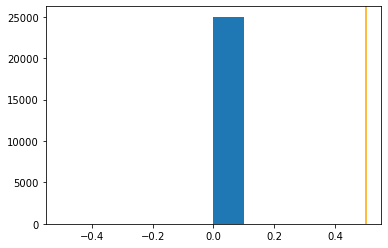

In [27]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [28]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'50.00'

In [29]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

IndexError: invalid index to scalar variable.

In [ ]:
' '.join(index_word[id] for id in all_x_valid[0])